In [1]:
#!/usr/bin/env python3
import os
import sys
import argparse
import numpy as np
import re
from glob import glob
import time
import importlib
import yaml

sys.path.append('./DMCF')
sys.path.append('./DMCF/scripts')

from o3d.utils import convert_device_name, Config
import tensorflow as tf
from datasets import DatasetGroup
import pipelines
import models

import multiprocessing

multiprocessing.set_start_method('spawn', True)

import random
import numpy as np


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2023-03-03 11:08:48.903279: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-03-03 11:08:50.866357: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-03 11:08:51.714563: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-03 11:08:51.714680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 11:08:51.714794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.867GHz coreCount: 28 deviceMemorySize: 11.74GiB deviceMemoryBandwidth: 335.32GiB/s
2023-03-03 11:08:51.714810: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-03 11:08:51.714851: I tensorflow/stream_executor/

In [27]:
import argparse
import copy
import os
import sys
import os.path as osp
from pathlib import Path
import yaml
import time
import pprint
import importlib

def parse_args():
    parser = argparse.ArgumentParser(description='Train a network')
    parser.add_argument('-c', '--cfg_file', help='path to the config file')
    parser.add_argument('-m', '--model', help='network model')
    parser.add_argument('-p',
                        '--pipeline',
                        help='pipeline',
                        default='DefaultGenerator')
    parser.add_argument('-d', '--dataset', help='dataset')
    parser.add_argument('--cfg_model', help='path to the model\'s config file')
    parser.add_argument('--cfg_pipeline',
                        help='path to the pipeline\'s config file')
    parser.add_argument('--cfg_dataset',
                        help='path to the dataset\'s config file')
    parser.add_argument('--dataset_path', help='path to the dataset')
    parser.add_argument('--ckpt_path', help='path to the checkpoint')
    parser.add_argument('--device',
                        help='device to run the pipeline',
                        default='gpu')
    parser.add_argument('--split', help='train or test', default='train')
    parser.add_argument('--regen',
                        help='Regenerates data, overwrites cache',
                        default=False,
                        action='store_true')
    parser.add_argument(
        '--restart',
        help='Restart training, resume if false (overwrites checkpoints!)',
        default=False,
        action='store_true')
    parser.add_argument('--main_log_dir',
                        help='the dir to save logs and models')
    parser.add_argument('--output_dir', help='the dir to save outputs')

#     args, unknown = parser.parse_known_args("--cfg_file DMCF/configs/WBC-SPH.yml --dataset_path ../../datasets/WBCSPH2D --split train --ckpt_path DMCF/checkpoints/WBC-SPH/ckpt".split())
#     args, unknown = parser.parse_known_args("--cfg_file DMCF/configs/WBC-SPH.yml --dataset_path ../../datasets/WBCSPH2D --split train --ckpt_path DMCF/checkpoints/WBC-SPH/ckpt".split())
    args, unknown = parser.parse_known_args("--cfg_file DMCF/configs/WBC-SPH.yml --dataset_path ../../datasets/WBCSPH2D --split train --ckpt_path DMCF/logs/SymNet_ComplexData_2d/checkpoint/ckpt-51".split())

    parser_extra = argparse.ArgumentParser(description='Extra arguments')
    for arg in unknown:
        if arg.startswith(("-", "--")):
            parser_extra.add_argument(arg)
    args_extra = parser_extra.parse_args(unknown)

    print("regular arguments")
    print(yaml.dump(vars(args)))

    print("extra arguments")
    print(yaml.dump(vars(args_extra)))

    return args, vars(args_extra)

In [28]:
args, extra_dict = parse_args()

regular arguments
cfg_dataset: null
cfg_file: DMCF/configs/WBC-SPH.yml
cfg_model: null
cfg_pipeline: null
ckpt_path: DMCF/logs/SymNet_ComplexData_2d/checkpoint/ckpt-51
dataset: null
dataset_path: ../../datasets/WBCSPH2D
device: gpu
main_log_dir: null
model: null
output_dir: null
pipeline: DefaultGenerator
regen: false
restart: false
split: train

extra arguments
{}



In [29]:


cfg = Config.load_from_file('./DMCF/configs/WBC-SPH.yml')
# cfg = Config.load_from_file('./DMCF/configs/other/cconv.yml')

Pipeline = getattr(pipelines, cfg.pipeline.name)
Model = getattr(models, cfg.model.name)

cfg_dict_dataset, cfg_dict_pipeline, cfg_dict_model = \
                Config.merge_cfg_file(cfg, args, extra_dict)

dataset = DatasetGroup(**cfg_dict_dataset,
                       split=args.split,
                       regen=args.regen)
model = Model(**cfg_dict_model)
pipeline = Pipeline(model,
                    dataset,
                    **cfg_dict_pipeline,
                    restart=args.restart)

['../../datasets/WBCSPH2D/train/sim_0000_00.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0000_01.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0000_02.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0000_03.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0000_04.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0000_05.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0000_06.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0000_07.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0002_00.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0002_01.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0002_02.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0002_03.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0002_04.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0002_05.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0002_06.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0002_07.msgpack.zst', '../../datasets/WBCSPH2D/train/sim_0003_00.msgpack.zst', '../../datasets/WBCSPH2D/train

In [30]:

model = Model(**cfg_dict_model)
# model.init()
# model.load_weights('./DMCF/checkpoints/WBC-SPH/', by_name=True)


In [31]:

cmd_line = ' '.join(sys.argv[:])
    
pipeline.cfg_tb = {
    'cmd_line': cmd_line,
    'dataset': pprint.pformat(cfg_dict_dataset, indent=2),
    'model': pprint.pformat(cfg_dict_model, indent=2),
    'pipeline': pprint.pformat(cfg_dict_pipeline, indent=2)
}

In [32]:
# pipeline.model.init()

In [33]:
from keras.utils.layer_utils import count_params

trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 0
Trainable params: 0
Non-trainable params: 0


In [34]:
pipeline.run_train()

INFO - 2023-03-03 11:15:06,490 - simulator - Logging in file : ./logs/SymNet_ComplexData_2d/log_train_2023-03-03_11:15:06.txt
INFO - 2023-03-03 11:15:16,539 - base_pipeline - Restored from DMCF/logs/SymNet_ComplexData_2d/checkpoint/ckpt-51
INFO - 2023-03-03 11:15:16,540 - simulator - Writing summary in ./train_log/00007_SymNet_ComplexData_2d.
INFO - 2023-03-03 11:15:16,543 - simulator - Started training
INFO - 2023-03-03 11:15:16,544 - simulator - === EPOCH 0/50 ===
training:   0%|                                                                          | 0/1000 [00:00<?, ?it/s]2023-03-03 11:15:44.346452: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: while_1/body/_415/while_1/Assert_7/AssertGuard/branch_executed/_4037
/home/winchenbach/dev/pytorchSPH2/Cconv/./DMCF/pipelines/base_pipeline.py:124: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.

In [35]:
from keras.utils.layer_utils import count_params

trainable_count = count_params(pipeline.model.trainable_weights)
non_trainable_count = count_params(pipeline.model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 537,376
Trainable params: 537,376
Non-trainable params: 0


In [36]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

import os
import sys
import numpy as np
from glob import glob
import dataflow
import numpy as np
import zstandard as zstd
import msgpack
import msgpack_numpy
msgpack_numpy.patch()

from tqdm.notebook import trange, tqdm
from rbfNet import *

from plotting import *
plt.style.use('dark_background')
# plt.style.use('default')
from tqdm.notebook import trange, tqdm
decompressor = zstd.ZstdDecompressor()
from rbfNet import *
from tqdm.notebook import trange, tqdm

/home/winchenbach/anaconda3/envs/DeepLagrangianFluids/lib/python3.9/site-packages/IPython/core/pylabtools.py:360: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.switch_backend(backend)


In [37]:
def getGroundTruth(fileName, frameIndex):
    attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
    return inputData['fluidPosition'].to(device), inputData['fluidVelocity'].to(device)
def getFrameCount(file):
    if 'zst' in file:
        with open(os.path.expanduser(file), 'rb') as f:
            data = msgpack.unpackb(decompressor.decompress(f.read()), raw=False)
            
#             print(data[0]['grav'])
            return len(data)
    if 'hdf5' in file:        
        inFile = h5py.File(file)
        length = len(inFile['simulationExport'].keys())
#         print(inFile.attrs['fluidGravity'])
        inFile.close()
        return length

extension = '.hdf5'

basePath = os.path.expanduser('~/dev/datasets/WBCSPH2Dc')
trainFiles = glob(os.path.join(os.path.join(basePath, 'train'), '*' + extension))
validFiles = glob(os.path.join(os.path.join(basePath, 'valid'), '*' + extension))
testFiles = glob(os.path.join(os.path.join(basePath, 'test'), '*' + extension))

# print(trainFiles)
# print(validFiles)
# print(testFiles)

simulationFiles = sorted(trainFiles + validFiles + testFiles)
# simulationFiles = ['/home/winchenbach/dev/datasets/WBCSPH2Dc/train/sim_0043.hdf5']

simFiles = ['/'.join(s.split('/')[-2:]) for s in simulationFiles]
debugPrint(simFiles)

frameCounts = []
fluidCounts = []
boundaryCounts = []

for s in tqdm(simulationFiles): 
    inFile = h5py.File(s)
    length = len(inFile['simulationExport'].keys())
    numFluids = inFile['simulationExport']['00000']['fluidPosition'].shape[0]
    numBoundary = inFile['boundaryInformation']['boundaryPosition'].shape[0]
    inFile.close()
    frameCounts.append(length)
    fluidCounts.append(numFluids)
    boundaryCounts.append(numBoundary)
    print('simulation %s has %4d frames, %5d fluid ptcls, %5d bdy ptcls'% ('/'.join(s.split('/')[-2:]).split('.')[0], length, numFluids, numBoundary))

simFiles [list] = ['test/sim_0006.hdf5', 'test/sim_0024.hdf5', 'test/sim_0049.hdf5', 'test/sim_0060.hdf5', 'test/sim_0061.hdf5', 'test/sim_0062.hdf5', 'test/sim_0063.hdf5', 'test/sim_0065.hdf5', 'test/sim_0066.hdf5', 'test/sim_0067.hdf5', 'test/sim_0068.hdf5', 'test/sim_0069.hdf5', 'train/sim_0000.hdf5', 'train/sim_0002.hdf5', 'train/sim_0003.hdf5', 'train/sim_0004.hdf5', 'train/sim_0005.hdf5', 'train/sim_0006.hdf5', 'train/sim_0007.hdf5', 'train/sim_0010.hdf5', 'train/sim_0012.hdf5', 'train/sim_0013.hdf5', 'train/sim_0014.hdf5', 'train/sim_0016.hdf5', 'train/sim_0018.hdf5', 'train/sim_0019.hdf5', 'train/sim_0020.hdf5', 'train/sim_0021.hdf5', 'train/sim_0022.hdf5', 'train/sim_0023.hdf5', 'train/sim_0024.hdf5', 'train/sim_0026.hdf5', 'train/sim_0028.hdf5', 'train/sim_0029.hdf5', 'train/sim_0030.hdf5', 'train/sim_0031.hdf5', 'train/sim_0032.hdf5', 'train/sim_0033.hdf5', 'train/sim_0034.hdf5', 'train/sim_0036.hdf5', 'train/sim_0039.hdf5', 'train/sim_0040.hdf5', 'train/sim_0043.hdf5', 'tra

  0%|          | 0/59 [00:00<?, ?it/s]

simulation test/sim_0006 has  300 frames,  1104 fluid ptcls,  6144 bdy ptcls
simulation test/sim_0024 has  300 frames,  7728 fluid ptcls,  6144 bdy ptcls
simulation test/sim_0049 has  200 frames, 16928 fluid ptcls,  6144 bdy ptcls
simulation test/sim_0060 has 3200 frames,  6034 fluid ptcls, 18326 bdy ptcls
simulation test/sim_0061 has 3200 frames,  2009 fluid ptcls, 18288 bdy ptcls
simulation test/sim_0062 has 3200 frames, 11259 fluid ptcls, 11948 bdy ptcls
simulation test/sim_0063 has 3200 frames,  8371 fluid ptcls, 13896 bdy ptcls
simulation test/sim_0065 has 3200 frames, 11530 fluid ptcls, 10863 bdy ptcls
simulation test/sim_0066 has 3200 frames, 13484 fluid ptcls, 15103 bdy ptcls
simulation test/sim_0067 has 3200 frames, 10824 fluid ptcls, 13261 bdy ptcls
simulation test/sim_0068 has 3200 frames,  8851 fluid ptcls, 11829 bdy ptcls
simulation test/sim_0069 has 3200 frames,  8864 fluid ptcls,  8579 bdy ptcls
simulation train/sim_0000 has 3200 frames,  7062 fluid ptcls, 16057 bdy ptcl

<IPython.core.display.Javascript object>


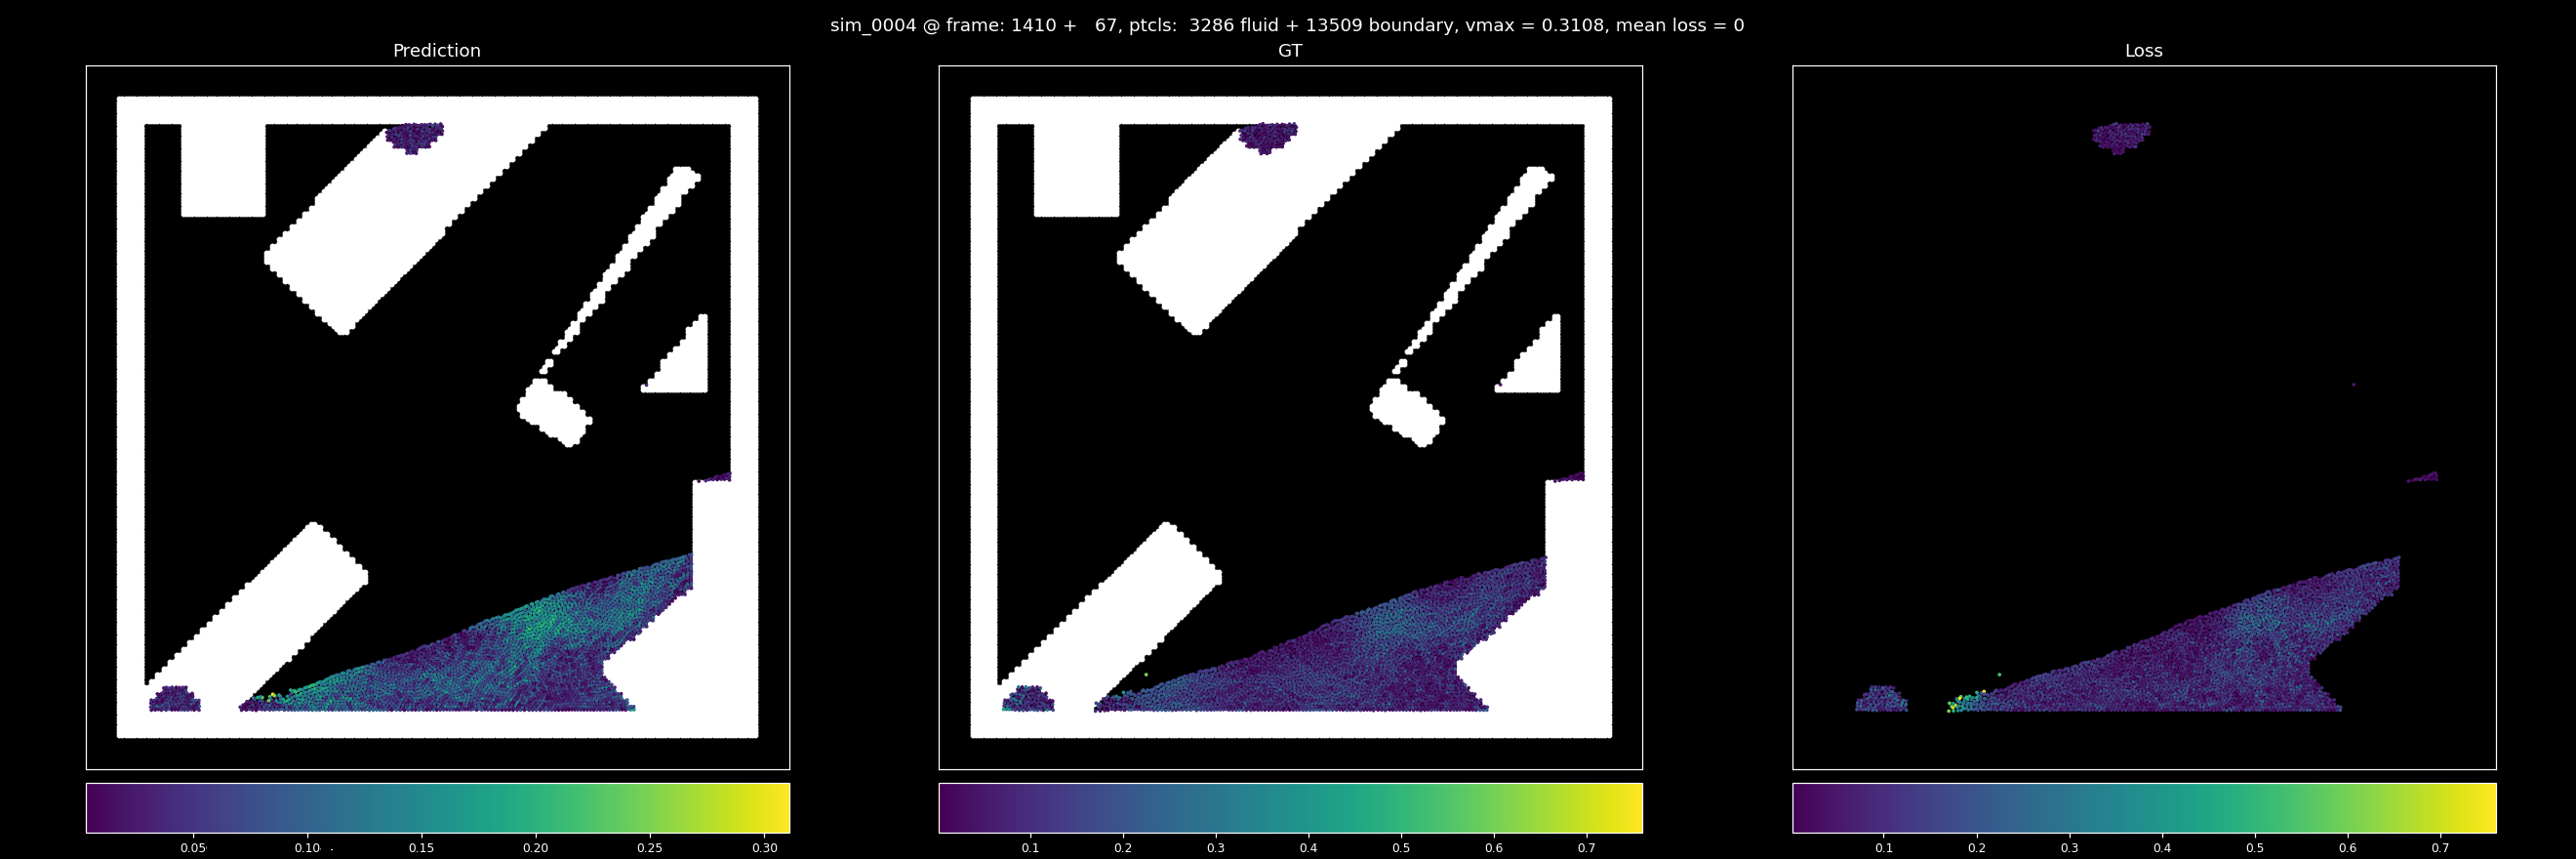

interactive(children=(Dropdown(description='fileName', options=('test/sim_0006.hdf5', 'test/sim_0024.hdf5', 't…

<function __main__.plotNetwork(fileName, frame)>

In [38]:
def plotNetwork(fileName, frame):
    global prevFile, prevFrame   
    
    file = basePath + '/' + fileName
    
    if file != prevFile:
        frameSlider.max = getFrameCount(file) - 1
        frameSlider.value = 0
        frame = 0        
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(0), 1)        
    if file != prevFile:
        bdyScatter0.set_offsets(inputData['boundaryPosition'][:,:2])
        bdyScatter1.set_offsets(inputData['boundaryPosition'][:,:2])
#         bdyScatter2.set_offsets(inputData['boundaryPosition'][:,:2])
        prevFile = file        
    if frame != prevFrame:
        prevFrame = frame
    data = torch.linalg.norm(inputData['fluidVelocity'],dim=1).detach().cpu().numpy()
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    sc0.set_offsets(positions)
    sc0.set_array(data)
    cbar0.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))    
    sc1.set_offsets(positions)
    sc1.set_array(data)
    cbar1.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))        
    sc2.set_offsets(positions)
    sc2.set_array(data)
    cbar2.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))        
    
#     axis[0,0].set_title('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.suptitle('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.canvas.draw()
    fig.canvas.flush_events()
   

fig, axis = plt.subplots(1, 3, figsize=(24,8), sharex = False, sharey = False, squeeze = False)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-0.05,1.05)
axis[0,0].set_ylim(-0.05,1.05)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-0.05,1.05)
axis[0,1].set_ylim(-0.05,1.05)
axis[0,2].axis('equal')
axis[0,2].set_xlim(-0.05,1.05)
axis[0,2].set_ylim(-0.05,1.05)

attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(1), 1)
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(inputData['fluidVelocity'],dim=1)

bdyScatter0 = axis[0,0].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )
bdyScatter1 = axis[0,1].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )
# bdyScatter2 = axis[0,2].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )

sc0 = axis[0,0].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar0 = fig.colorbar(sc0, cax=cax1,orientation='horizontal')
cbar0.ax.tick_params(labelsize=8) 

sc1 = axis[0,1].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar1 = fig.colorbar(sc1, cax=cax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=8) 

sc2 = axis[0,2].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar2 = fig.colorbar(sc2, cax=cax1,orientation='horizontal')
cbar2.ax.tick_params(labelsize=8) 

fig.suptitle('%s @ %2d' % (simulationFiles[0].split('/')[-1].split('.')[0], 0))
axis[0,0].set_title('Prediction')
axis[0,1].set_title('GT')
axis[0,2].set_title('Loss')
    
prevFile = None
prevFrame = None
        
axis[0,0].set_xticks([], [])
axis[0,0].set_yticks([], [])
axis[0,1].set_xticks([], [])
axis[0,1].set_yticks([], [])
axis[0,2].set_xticks([], [])
axis[0,2].set_yticks([], [])
    
frameSlider = widgets.IntSlider(value=0, min=0, max=getFrameCount(simulationFiles[0]) - 1, step=1)

fig.tight_layout()

interact(plotNetwork, fileName = simFiles, frame = frameSlider)

In [40]:
print(prevFile)
print(prevFrame)
fileName = prevFile
frameIndex = prevFrame
    
# params = getRbfNetworkParams(fileName, frameIndex)
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 0 + np.arange(1))
inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
gt = getGroundTruth(fileName, 10)

predictedPositions = inputData['fluidPosition'].to(device)
predictedVelocities = inputData['fluidVelocity'].to(device)
dt = attributes['dt']

pr_pos = tf.convert_to_tensor(predictedPositions.detach().cpu().numpy())
pr_vel = tf.convert_to_tensor(predictedVelocities.detach().cpu().numpy())
acc = tf.convert_to_tensor(inputData['fluidGravity'].detach().cpu().numpy())

box = tf.convert_to_tensor(boundaryPositions.detach().cpu().numpy())
box_normals = tf.convert_to_tensor(boundaryFeatures.detach().cpu().numpy())

pr_pos = tf.concat ([pr_pos, tf.zeros((pr_pos.shape[0],1))], axis = 1)
pr_vel = tf.concat ([pr_vel, tf.zeros((pr_pos.shape[0],1))], axis = 1)
acc = tf.concat ([acc, tf.zeros((pr_pos.shape[0],1))], axis = 1)

box = tf.concat ([box, tf.zeros((box.shape[0],1))], axis = 1)
# box_normals = tf.concat ([box_normals, tf.zeros((box_normals.shape[0],1))], axis = 1)


for i in range(1, 128):
    inputs = (pr_pos, pr_vel, acc, None, box, box_normals)
    pr_pos, pr_vel = pipeline.model(inputs, training=False)    
    
    gt = getGroundTruth(fileName, prevFrame + i)
#     predictedPositions, predictedVelocities, loss = runRbfNetwork(predictedPositions, predictedVelocities, attributes['dt'], 1, params, gt, True)
    
    data = np.linalg.norm(pr_vel.numpy(),axis=1)    
    sc0.set_offsets(pr_pos.numpy())
    sc0.set_array(data)
    cbar0.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))    
    
    gtdata = np.linalg.norm(gt[1].detach().cpu().numpy(), axis = 1)
    sc1.set_offsets(gt[0].detach().cpu().numpy())
    sc1.set_array(gtdata)
    sc2.set_offsets(gt[0].detach().cpu().numpy())
#     sc2.set_array(loss.detach().cpu().numpy())
    
    fig.suptitle('%s @ frame: %4d + %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g, mean loss = %.4g' % (prevFile.split('/')[-1].split('.')[0], prevFrame, i, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data), 0.))
    fig.canvas.draw()
    fig.canvas.flush_events()
    


/home/winchenbach/dev/datasets/WBCSPH2Dc/train/sim_0004.hdf5
1410


KeyboardInterrupt: 

In [24]:
print(acc)

tf.Tensor(
[[ 0.   -9.81  0.  ]
 [ 0.   -9.81  0.  ]
 [ 0.   -9.81  0.  ]
 ...
 [ 0.   -9.81  0.  ]
 [ 0.   -9.81  0.  ]
 [ 0.   -9.81  0.  ]], shape=(1104, 3), dtype=float32)
